In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                            ConfusionMatrixDisplay, accuracy_score, f1_score)
import warnings
import time

warnings.filterwarnings('ignore')

# Yapılandırma Parametreleri
SAMPLE_SIZE = 500000
TEST_RATIO = 0.2
RANDOM_STATE = 42
MODEL_PARAMS = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

print("✓ Tüm kütüphaneler başarıyla yüklendi!")
print(f"✓ Örnek boyutu: {SAMPLE_SIZE:,}")
print(f"✓ Test oranı: {TEST_RATIO}")

✓ Tüm kütüphaneler başarıyla yüklendi!
✓ Örnek boyutu: 500,000
✓ Test oranı: 0.2


In [2]:
def load_and_split_data(filepath, sample_size, test_size, random_state):
    """Ham veriyi yükler, örnekler ve train/test olarak böler."""
    print("\n" + "="*80)
    print("VERİ YÜKLEME VE BÖLME İŞLEMİ")
    print("="*80)
    
    raw_data = pd.read_csv(filepath)
    print(f"→ Toplam kayıt sayısı: {len(raw_data):,}")
    
    sampled_data = raw_data.sample(n=sample_size, random_state=random_state)
    del raw_data
    print(f"→ Örneklenen kayıt sayısı: {len(sampled_data):,}")
    
    features = sampled_data.drop('Severity', axis=1)
    target = sampled_data['Severity']
    
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=target
    )
    
    print(f"→ Eğitim seti: {X_train.shape[0]:,} satır × {X_train.shape[1]} özellik")
    print(f"→ Test seti: {X_test.shape[0]:,} satır × {X_test.shape[1]} özellik")
    
    return X_train, X_test, y_train, y_test

print("✓ Veri yükleme fonksiyonu tanımlandı")

✓ Veri yükleme fonksiyonu tanımlandı


In [3]:
def engineer_temporal_features(df):
    """Zaman tabanlı özellikler üretir."""
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    
    df['Hour_of_Day'] = df['Start_Time'].dt.hour
    df['Day_Name'] = df['Start_Time'].dt.day_name()
    df['Is_Weekend_Day'] = df['Day_Name'].isin(['Saturday', 'Sunday']).astype(int)
    
    rush_hours = [7, 8, 9, 16, 17, 18]
    df['During_Rush_Hour'] = df['Hour_of_Day'].isin(rush_hours).astype(int)
    
    duration_seconds = (df['End_Time'] - df['Start_Time']).dt.total_seconds()
    df['Accident_Duration_Min'] = (duration_seconds / 60).clip(lower=0)
    
    night_hours = list(range(0, 6)) + [22, 23]
    df['Night_Weekend_Combo'] = (
        (df['Is_Weekend_Day'] == 1) & 
        (df['Hour_of_Day'].isin(night_hours))
    ).astype(int)
    
    return df


def engineer_weather_features(df):
    """Hava durumu ile ilgili özellikler üretir."""
    if 'Weather_Condition' in df.columns:
        df['Weather_Condition'] = df['Weather_Condition'].fillna('Clear')
        
        adverse_keywords = [
            'rain', 'snow', 'storm', 'thunder', 'fog', 
            'ice', 'sleet', 'wintry', 'drizzle', 'hail', 'mist'
        ]
        
        pattern = '|'.join(adverse_keywords)
        df['Adverse_Weather'] = (
            df['Weather_Condition']
            .str.lower()
            .str.contains(pattern, na=False)
            .astype(int)
        )
    
    if 'Precipitation(in)' in df.columns:
        df['Precipitation(in)'] = df['Precipitation(in)'].fillna(0.0)
        df['Has_Precipitation'] = (df['Precipitation(in)'] > 0).astype(int)
    
    return df


def engineer_traffic_features(df):
    """Trafik ve yol koşulu özellikleri üretir."""
    if all(col in df.columns for col in ['Traffic_Signal', 'Stop']):
        df['Signal_Stop_Present'] = (
            (df['Traffic_Signal'] == True) | 
            (df['Stop'] == True)
        ).astype(int)
    
    df['Heavy_Traffic_Indicator'] = (
        (df['During_Rush_Hour'] == 1) & 
        (df['Signal_Stop_Present'] == 1)
    ).astype(int)
    
    if 'Junction' in df.columns:
        df['Junction'] = df['Junction'].astype(int)
    
    return df


def engineer_severity_indicators(df):
    """Kaza şiddeti göstergeleri üretir."""
    if all(col in df.columns for col in ['Distance(mi)', 'Accident_Duration_Min']):
        distance_threshold = df['Distance(mi)'].quantile(0.75)
        duration_threshold = df['Accident_Duration_Min'].quantile(0.75)
        
        df['High_Impact_Incident'] = (
            (df['Distance(mi)'] > distance_threshold) & 
            (df['Accident_Duration_Min'] > duration_threshold)
        ).astype(int)
    
    return df


def create_all_features(data):
    """Tüm özellik mühendisliği işlemlerini uygular."""
    print("\n" + "-"*80)
    print("ÖZELLİK MÜHENDİSLİĞİ UYGULANMAKTADIR...")
    print("-"*80)
    
    processed = data.copy()
    
    print("  ✓ Zaman tabanlı özellikler oluşturuluyor...")
    processed = engineer_temporal_features(processed)
    
    print("  ✓ Hava durumu özellikleri oluşturuluyor...")
    processed = engineer_weather_features(processed)
    
    print("  ✓ Trafik özellikleri oluşturuluyor...")
    processed = engineer_traffic_features(processed)
    
    print("  ✓ Şiddet göstergeleri oluşturuluyor...")
    processed = engineer_severity_indicators(processed)
    
    print("  → Özellik mühendisliği tamamlandı.")
    
    return processed

print("✓ Özellik mühendisliği fonksiyonları tanımlandı")

✓ Özellik mühendisliği fonksiyonları tanımlandı


In [ ]:
def remove_unnecessary_columns(df):
    """Gereksiz sütunları temizler."""
    columns_to_remove = [
        'ID', 'Source', 'End_Lat', 'End_Lng', 'County', 'Zipcode', 
        'Country', 'Start_Time', 'End_Time', 'Timezone', 'Airport_Code',
        'Weather_Timestamp', 'Wind_Chill(F)', 'Street', 'Description',
        'Weather_Condition', 'City'
    ]
    
    df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')
    return df_cleaned


def handle_outliers(train_df, test_df):
    """Aykırı değerleri kırpar (clipping)."""
    print("\n  ✓ Aykırı değerler işleniyor...")
    
    numerical_cols = [
        'Temperature(F)', 'Wind_Speed(mph)', 'Precipitation(in)',
        'Distance(mi)', 'Accident_Duration_Min', 'Pressure(in)',
        'Humidity(%)', 'Visibility(mi)'
    ]
    
    available_cols = [col for col in numerical_cols if col in train_df.columns]
    
    for column in available_cols:
        lower_bound = train_df[column].quantile(0.01)
        upper_bound = train_df[column].quantile(0.99)
        
        train_df[column] = train_df[column].clip(lower=lower_bound, upper=upper_bound)
        test_df[column] = test_df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return train_df, test_df


def impute_missing_values(train_df, test_df):
    """Eksik değerleri doldurur."""
    print("  ✓ Eksik değerler dolduruluyor...")
    
    fill_strategy = {}
    
    for column in train_df.columns:
        if train_df[column].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(train_df[column]):
                fill_strategy[column] = train_df[column].median()
            else:
                mode_values = train_df[column].mode()
                fill_strategy[column] = mode_values[0] if len(mode_values) > 0 else 'Unknown'
    
    train_df = train_df.fillna(value=fill_strategy)
    test_df = test_df.fillna(value=fill_strategy)
    
    return train_df, test_df


def preprocess_data(X_train, X_test):
    """Veri ön işleme adımlarını yönetir."""
    print("\n" + "-"*80)
    print("VERİ TEMİZLEME VE ÖN İŞLEME")
    print("-"*80)
    
    X_train_clean = remove_unnecessary_columns(X_train)
    X_test_clean = remove_unnecessary_columns(X_test)
    
    X_train_clean, X_test_clean = handle_outliers(X_train_clean, X_test_clean)
    X_train_clean, X_test_clean = impute_missing_values(X_train_clean, X_test_clean)
    
    print(f"  → Temizlenmiş veri seti boyutu: {X_train_clean.shape[1]} özellik")
    
    return X_train_clean, X_test_clean

print("✓ Veri temizleme fonksiyonları tanımlandı")

✓ Veri temizleme fonksiyonları tanımlandı


In [5]:
def encode_and_scale(X_train, X_test):
    """Kategorik değişkenleri kodlar ve sayısal değerleri ölçeklendirir."""
    print("\n" + "-"*80)
    print("KODLAMA VE ÖLÇEKLENDİRME")
    print("-"*80)
    
    categorical_columns = [
        col for col in ['Day_Name', 'State', 'Wind_Direction', 
                       'Sunrise_Sunset', 'Civil_Twilight', 
                       'Nautical_Twilight', 'Astronomical_Twilight']
        if col in X_train.columns
    ]
    
    print(f"  ✓ {len(categorical_columns)} kategorik özellik kodlanıyor...")
    
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)
    
    missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
    for col in missing_cols:
        X_test_encoded[col] = 0
    
    X_test_encoded = X_test_encoded[X_train_encoded.columns]
    
    numeric_columns = X_train_encoded.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"  ✓ {len(numeric_columns)} sayısal özellik ölçeklendiriliyor...")
    
    scaler = StandardScaler()
    
    X_train_final = X_train_encoded.copy()
    X_test_final = X_test_encoded.copy()
    
    X_train_final[numeric_columns] = scaler.fit_transform(X_train_encoded[numeric_columns])
    X_test_final[numeric_columns] = scaler.transform(X_test_encoded[numeric_columns])
    
    print(f"  → Nihai özellik sayısı: {X_train_final.shape[1]}")
    
    return X_train_final, X_test_final

print("✓ Kodlama ve ölçeklendirme fonksiyonu tanımlandı")

✓ Kodlama ve ölçeklendirme fonksiyonu tanımlandı


In [6]:
def build_and_train_model(X_train, y_train, model_params):
    """ADASYN + XGBoost pipeline oluşturur ve eğitir."""
    print("\n" + "="*80)
    print("MODEL EĞİTİMİ")
    print("="*80)
    
    y_train_adjusted = y_train - 1
    
    print(f"  → Sınıf dağılımı: {np.bincount(y_train_adjusted)}")
    print("\n  ✓ ADASYN + XGBoost pipeline oluşturuluyor...")
    
    adasyn_sampler = ADASYN(random_state=RANDOM_STATE, n_jobs=-1)
    xgb_model = xgb.XGBClassifier(**model_params)
    
    pipeline = ImbPipeline([
        ('sampling', adasyn_sampler),
        ('classification', xgb_model)
    ])
    
    print("  ✓ Model eğitimi başlatılıyor (bu işlem zaman alabilir)...")
    
    start = time.time()
    pipeline.fit(X_train, y_train_adjusted)
    duration = time.time() - start
    
    print(f"\n  → Eğitim tamamlandı! Süre: {duration:.2f} saniye ({duration/60:.2f} dakika)")
    
    return pipeline, y_train_adjusted

print("✓ Model eğitim fonksiyonu tanımlandı")

✓ Model eğitim fonksiyonu tanımlandı


In [7]:
def evaluate_model(pipeline, X_test, y_test):
    """Modeli değerlendirir ve metrikleri hesaplar."""
    print("\n" + "="*80)
    print("MODEL DEĞERLENDİRME")
    print("="*80)
    
    y_test_adjusted = y_test - 1
    
    print("  ✓ Tahminler yapılıyor...")
    predictions = pipeline.predict(X_test)
    
    acc = accuracy_score(y_test_adjusted, predictions)
    f1_weighted = f1_score(y_test_adjusted, predictions, average='weighted')
    f1_macro = f1_score(y_test_adjusted, predictions, average='macro')
    
    print(f"\n  → Doğruluk (Accuracy): {acc:.4f}")
    print(f"  → Ağırlıklı F1-Skoru: {f1_weighted:.4f}")
    print(f"  → Makro F1-Skoru: {f1_macro:.4f}")
    
    print("\n" + "-"*80)
    print("SINIFLANDIRMA RAPORU")
    print("-"*80)
    
    class_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
    report = classification_report(y_test_adjusted, predictions, 
                                   target_names=class_names)
    print(report)
    
    return predictions, y_test_adjusted


def plot_confusion_matrix(y_true, y_pred):
    """Karmaşıklık matrisini görselleştirir."""
    print("\n  ✓ Karmaşıklık matrisi oluşturuluyor...")
    
    cm = confusion_matrix(y_true, y_pred)
    class_labels = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
    
    fig, ax = plt.subplots(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', ax=ax, values_format='d')
    
    plt.title('Confusion Matrix - ADASYN + XGBoost Model', 
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def analyze_feature_importance(pipeline, feature_names, top_n=20):
    """Özellik önemlerini analiz eder ve görselleştirir."""
    print("\n" + "="*80)
    print("ÖZELLİK ÖNEMİ ANALİZİ")
    print("="*80)
    
    classifier = pipeline.named_steps['classification']
    
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': classifier.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\n  En Önemli {top_n} Özellik:")
    print("  " + "-"*50)
    for idx, row in importances.head(top_n).iterrows():
        print(f"  {row['Feature']:.<40} {row['Importance']:.4f}")
    
    plt.figure(figsize=(12, 8))
    top_features = importances.head(top_n)
    
    sns.barplot(data=top_features, x='Importance', y='Feature', 
               palette='viridis', edgecolor='black', linewidth=0.5)
    
    plt.title(f'Top {top_n} Most Important Features', 
             fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Importance Score', fontsize=11)
    plt.ylabel('Feature Name', fontsize=11)
    plt.tight_layout()
    plt.show()

print("✓ Değerlendirme ve görselleştirme fonksiyonları tanımlandı")

✓ Değerlendirme ve görselleştirme fonksiyonları tanımlandı


In [8]:
X_train, X_test, y_train, y_test = load_and_split_data(
    'US_Accidents_March23.csv',
    SAMPLE_SIZE,
    TEST_RATIO,
    RANDOM_STATE
)


VERİ YÜKLEME VE BÖLME İŞLEMİ
→ Toplam kayıt sayısı: 7,728,394
→ Örneklenen kayıt sayısı: 500,000
→ Eğitim seti: 400,000 satır × 45 özellik
→ Test seti: 100,000 satır × 45 özellik


In [9]:
X_train_featured = create_all_features(X_train)
X_test_featured = create_all_features(X_test)


--------------------------------------------------------------------------------
ÖZELLİK MÜHENDİSLİĞİ UYGULANMAKTADIR...
--------------------------------------------------------------------------------
  ✓ Zaman tabanlı özellikler oluşturuluyor...
  ✓ Hava durumu özellikleri oluşturuluyor...
  ✓ Trafik özellikleri oluşturuluyor...
  ✓ Şiddet göstergeleri oluşturuluyor...
  → Özellik mühendisliği tamamlandı.

--------------------------------------------------------------------------------
ÖZELLİK MÜHENDİSLİĞİ UYGULANMAKTADIR...
--------------------------------------------------------------------------------
  ✓ Zaman tabanlı özellikler oluşturuluyor...
  ✓ Hava durumu özellikleri oluşturuluyor...
  ✓ Trafik özellikleri oluşturuluyor...
  ✓ Şiddet göstergeleri oluşturuluyor...
  → Özellik mühendisliği tamamlandı.


In [10]:
X_train_clean, X_test_clean = preprocess_data(X_train_featured, X_test_featured)


--------------------------------------------------------------------------------
VERİ TEMİZLEME VE ÖN İŞLEME
--------------------------------------------------------------------------------

  ✓ Aykırı değerler işleniyor...
  ✓ Eksik değerler dolduruluyor...
  → Temizlenmiş veri seti boyutu: 38 özellik


In [11]:
X_train_final, X_test_final = encode_and_scale(X_train_clean, X_test_clean)


--------------------------------------------------------------------------------
KODLAMA VE ÖLÇEKLENDİRME
--------------------------------------------------------------------------------
  ✓ 7 kategorik özellik kodlanıyor...
  ✓ 19 sayısal özellik ölçeklendiriliyor...
  → Nihai özellik sayısı: 112


In [12]:
model, y_train_adj = build_and_train_model(X_train_final, y_train, MODEL_PARAMS)


MODEL EĞİTİMİ
  → Sınıf dağılımı: [  3507 318212  67634  10647]

  ✓ ADASYN + XGBoost pipeline oluşturuluyor...
  ✓ Model eğitimi başlatılıyor (bu işlem zaman alabilir)...

  → Eğitim tamamlandı! Süre: 90.31 saniye (1.51 dakika)


In [13]:
y_pred, y_test_adj = evaluate_model(model, X_test_final, y_test)


MODEL DEĞERLENDİRME
  ✓ Tahminler yapılıyor...

  → Doğruluk (Accuracy): 0.7338
  → Ağırlıklı F1-Skoru: 0.7576
  → Makro F1-Skoru: 0.4430

--------------------------------------------------------------------------------
SINIFLANDIRMA RAPORU
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Severity 1       0.11      0.62      0.19       876
  Severity 2       0.89      0.79      0.83     79553
  Severity 3       0.47      0.56      0.51     16909
  Severity 4       0.19      0.33      0.24      2662

    accuracy                           0.73    100000
   macro avg       0.41      0.57      0.44    100000
weighted avg       0.79      0.73      0.76    100000




  ✓ Karmaşıklık matrisi oluşturuluyor...


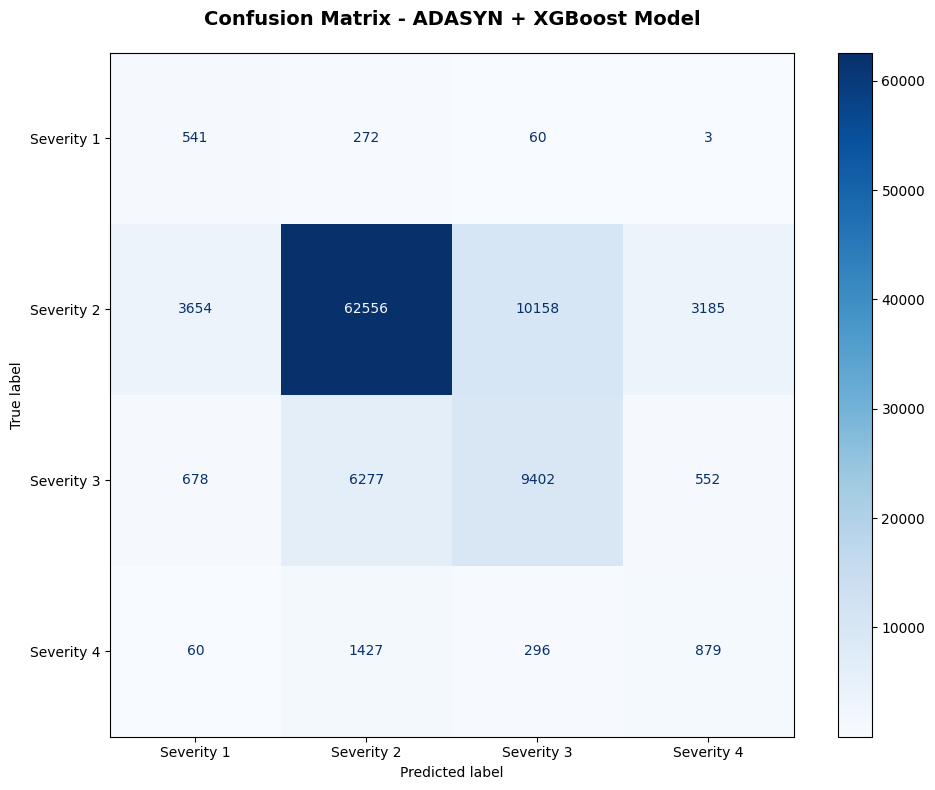

In [14]:
plot_confusion_matrix(y_test_adj, y_pred)


ÖZELLİK ÖNEMİ ANALİZİ

  En Önemli 20 Özellik:
  --------------------------------------------------
  Signal_Stop_Present..................... 0.0339
  Crossing................................ 0.0320
  Astronomical_Twilight_Night............. 0.0315
  State_AR................................ 0.0297
  Accident_Duration_Min................... 0.0290
  State_GA................................ 0.0269
  State_CO................................ 0.0260
  State_SC................................ 0.0257
  Traffic_Signal.......................... 0.0235
  State_MD................................ 0.0216
  Wind_Direction_Calm..................... 0.0213
  State_VA................................ 0.0189
  Temperature(F).......................... 0.0172
  Wind_Speed(mph)......................... 0.0167
  Wind_Direction_South.................... 0.0157
  Day_Name_Tuesday........................ 0.0152
  State_MA................................ 0.0150
  State_NC................................ 0.0147

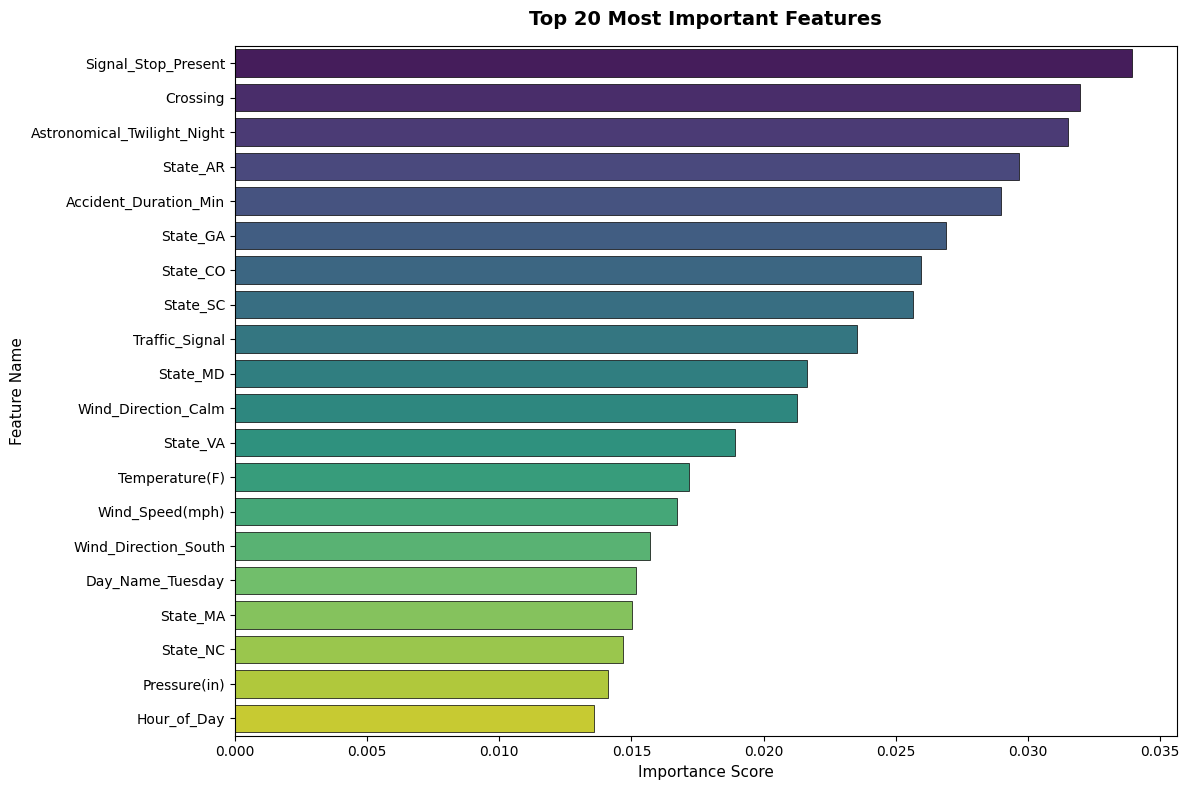

In [15]:
analyze_feature_importance(model, X_train_final.columns, top_n=20)

✓ Tüm kütüphaneler başarıyla yüklendi!
✓ Örnek boyutu: 500,000
✓ Test oranı: 0.2
✓ PCA komponenti: 0.95

ANA İŞ AKIŞI BAŞLATILIYOR

VERİ YÜKLEME VE BÖLME İŞLEMİ
→ Toplam kayıt sayısı: 7,728,394
→ Örneklenen kayıt sayısı: 500,000
→ Eğitim seti: 400,000 satır × 45 özellik
→ Test seti: 100,000 satır × 45 özellik

--------------------------------------------------------------------------------
SINIF DAĞILIMI ANALİZİ
--------------------------------------------------------------------------------


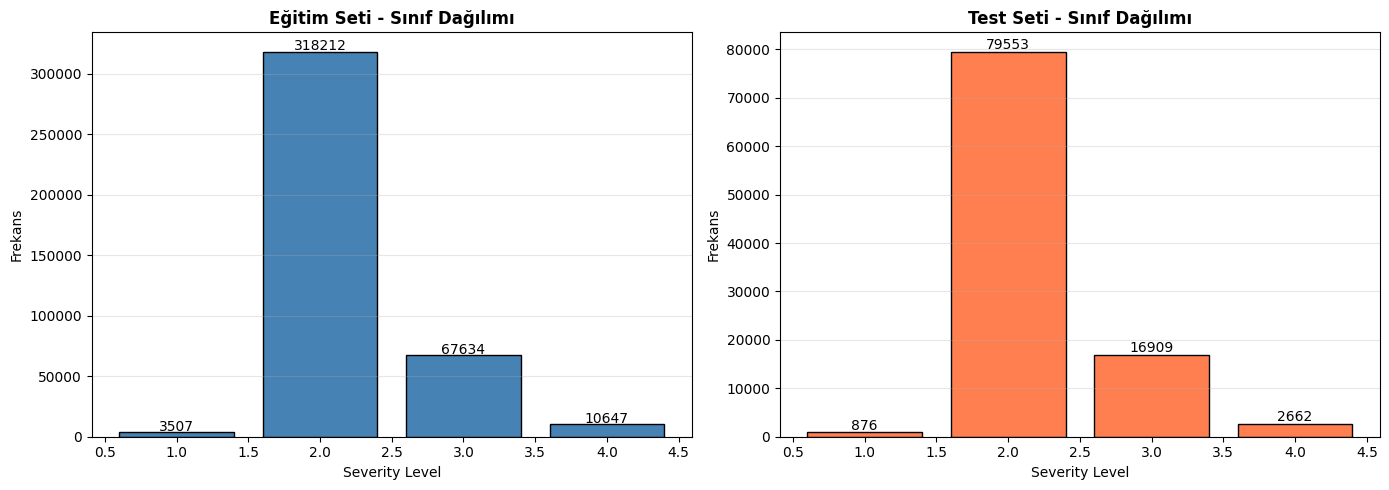


  Eğitim Seti:
    Severity 1: 3,507 (0.88%)
    Severity 2: 318,212 (79.55%)
    Severity 3: 67,634 (16.91%)
    Severity 4: 10,647 (2.66%)

  Test Seti:
    Severity 1: 876 (0.88%)
    Severity 2: 79,553 (79.55%)
    Severity 3: 16,909 (16.91%)
    Severity 4: 2,662 (2.66%)

--------------------------------------------------------------------------------
ÖZELLİK MÜHENDİSLİĞİ UYGULANMAKTADIR...
--------------------------------------------------------------------------------
  ✓ Zaman tabanlı özellikler oluşturuluyor...
  ✓ Hava durumu özellikleri oluşturuluyor...
  ✓ Trafik özellikleri oluşturuluyor...
  ✓ Şiddet göstergeleri oluşturuluyor...
  → Özellik mühendisliği tamamlandı.

--------------------------------------------------------------------------------
ÖZELLİK MÜHENDİSLİĞİ UYGULANMAKTADIR...
--------------------------------------------------------------------------------
  ✓ Zaman tabanlı özellikler oluşturuluyor...
  ✓ Hava durumu özellikleri oluşturuluyor...
  ✓ Trafik özell

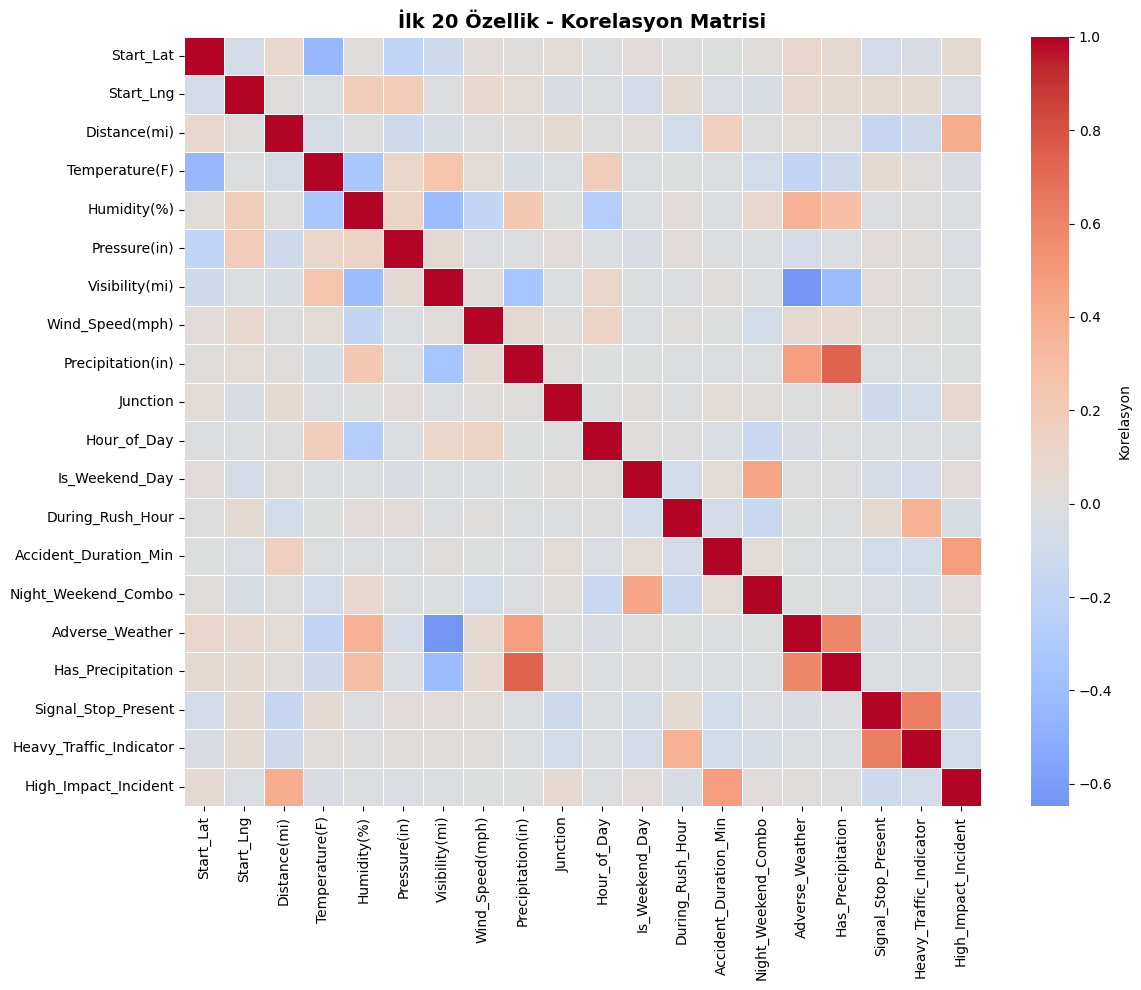


PCA (Temel Bileşen Analizi)
  ✓ PCA uygulanıyor (Varyans: %95.0)...
  → Seçilen bileşen sayısı: 36
  → Açıklanan toplam varyans: %95.03


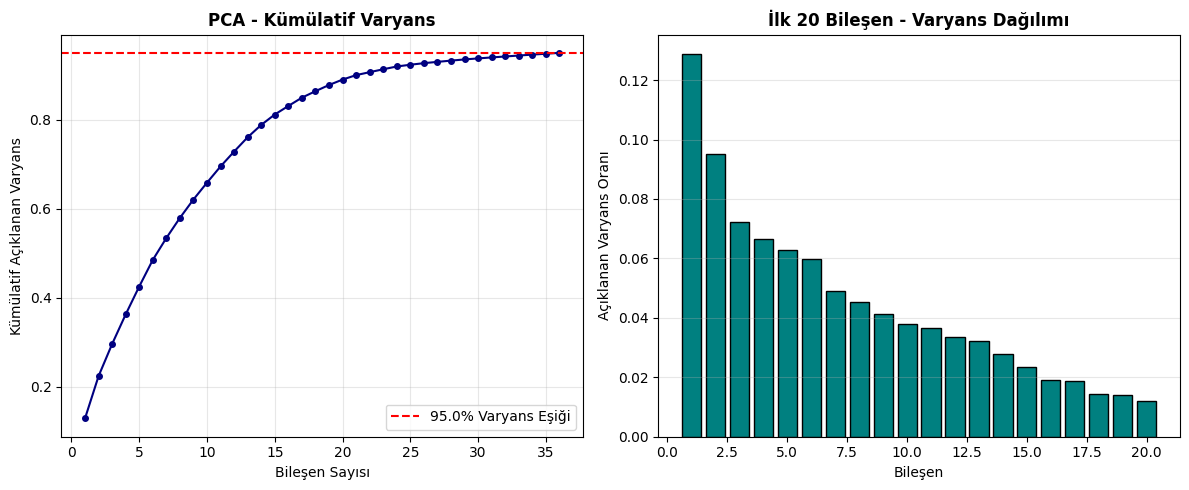


BASELINE MODEL 1: MAJORITY CLASS CLASSIFIER
  ✓ Model eğitiliyor...
  → Eğitim tamamlandı! Süre: 0.0000 saniye
  → En çok görülen sınıf: 1

  ✓ Tahminler yapılıyor...

  → Doğruluk (Accuracy): 0.7955
  → Ağırlıklı F1-Skoru: 0.7049

  ✓ Baseline 1: Majority Class - Karmaşıklık matrisi oluşturuluyor...


<Figure size 1000x800 with 0 Axes>

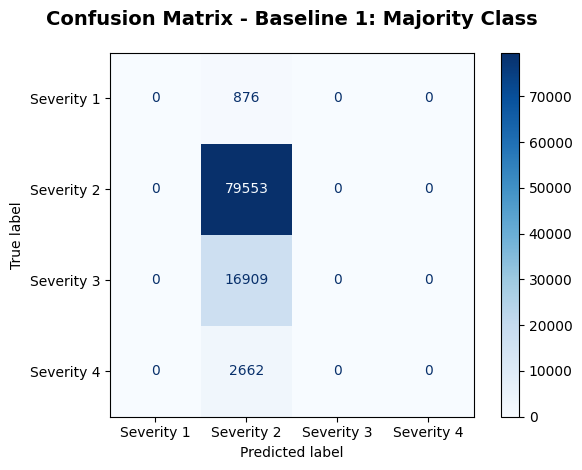


BASELINE MODEL 2: LOGISTIC REGRESSION
  ✓ Model eğitiliyor...
  → Eğitim tamamlandı! Süre: 5.78 saniye

  ✓ Tahminler yapılıyor...

  → Doğruluk (Accuracy): 0.7959
  → Ağırlıklı F1-Skoru: 0.7128

  ✓ Baseline 2: Logistic Regression - Karmaşıklık matrisi oluşturuluyor...


<Figure size 1000x800 with 0 Axes>

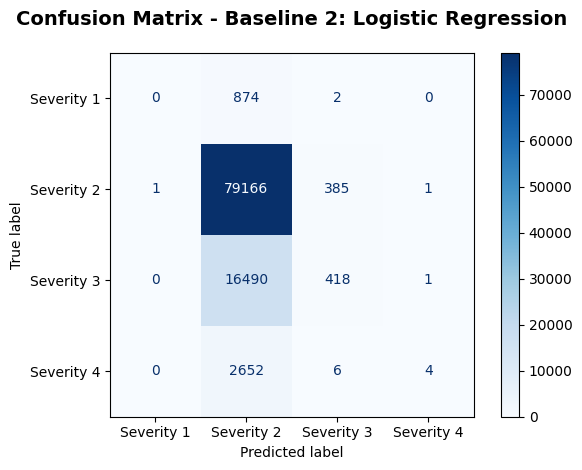


MODEL 3: SMOTE + XGBoost
  → Sınıf dağılımı: [  3507 318212  67634  10647]

  ✓ SMOTE + XGBoost pipeline oluşturuluyor...
  ✓ Model eğitimi başlatılıyor...

  → Eğitim tamamlandı! Süre: 49.88 saniye (0.83 dakika)

SMOTE + XGBOOST DEĞERLENDİRME
  ✓ Tahminler yapılıyor...

  → Doğruluk (Accuracy): 0.7571
  → Ağırlıklı F1-Skoru: 0.7787
  → Makro F1-Skoru: 0.4774

--------------------------------------------------------------------------------
SINIFLANDIRMA RAPORU
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Severity 1       0.14      0.63      0.22       876
  Severity 2       0.90      0.80      0.85     79553
  Severity 3       0.50      0.63      0.56     16909
  Severity 4       0.22      0.37      0.28      2662

    accuracy                           0.76    100000
   macro avg       0.44      0.61      0.48    100000
weighted avg       0.81      0.76      0.78    100000


  ✓ SMOTE + XGBoo

<Figure size 1000x800 with 0 Axes>

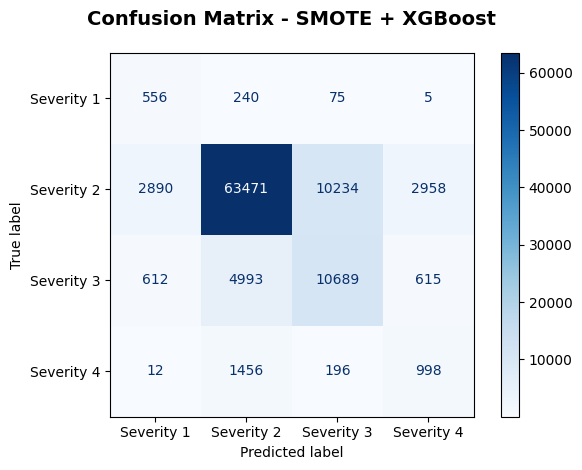


ÖZELLİK ÖNEMİ ANALİZİ

  En Önemli 20 Özellik:
  --------------------------------------------------
  Distance(mi)............................ 0.0766
  Signal_Stop_Present..................... 0.0694
  Crossing................................ 0.0404
  Wind_Direction_Calm..................... 0.0259
  State_SC................................ 0.0259
  State_GA................................ 0.0234
  State_AR................................ 0.0209
  Accident_Duration_Min................... 0.0201
  State_CO................................ 0.0196
  Traffic_Signal.......................... 0.0191
  Wind_Speed(mph)......................... 0.0190
  Astronomical_Twilight_Night............. 0.0173
  Pressure(in)............................ 0.0164
  Day_Name_Tuesday........................ 0.0147
  Day_Name_Wednesday...................... 0.0145
  Wind_Direction_South.................... 0.0139
  State_VA................................ 0.0137
  Day_Name_Thursday....................... 0.0137

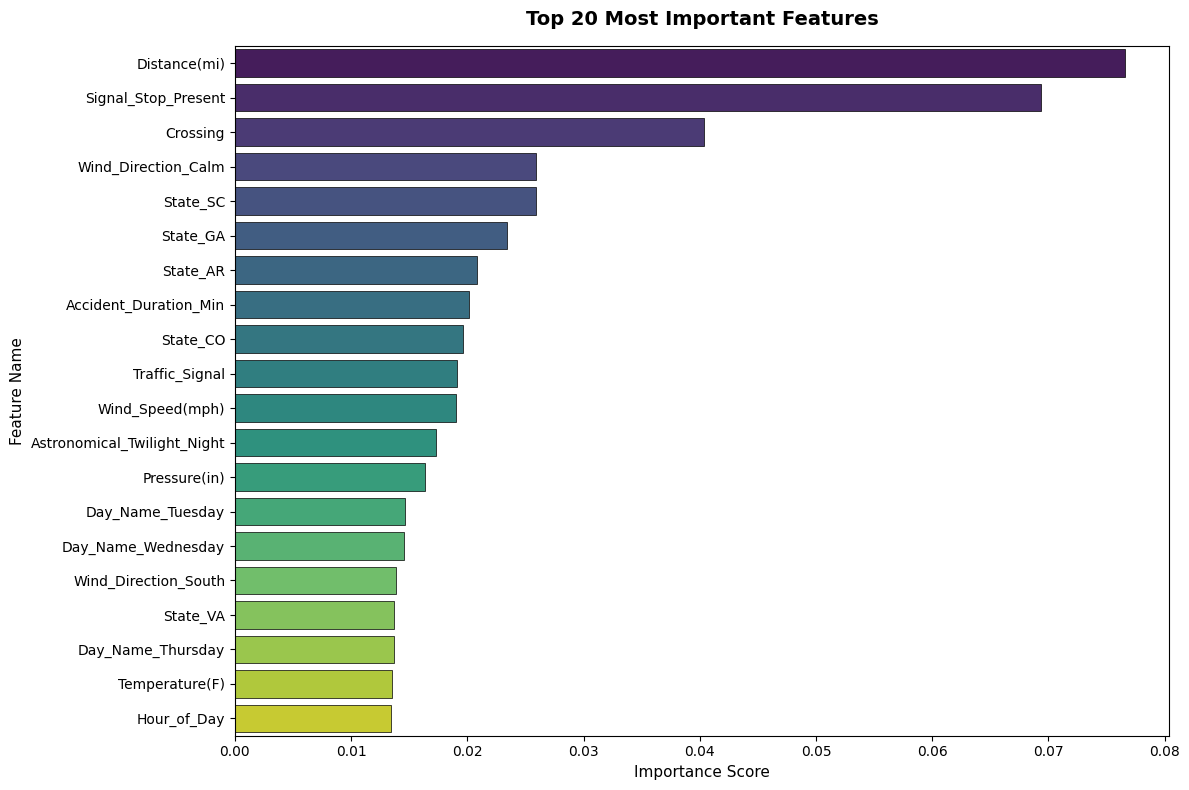


MODEL 4: ADASYN + XGBoost
  → Sınıf dağılımı: [  3507 318212  67634  10647]

  ✓ ADASYN + XGBoost pipeline oluşturuluyor...
  ✓ Model eğitimi başlatılıyor...

  → Eğitim tamamlandı! Süre: 96.64 saniye (1.61 dakika)

ADASYN + XGBOOST DEĞERLENDİRME
  ✓ Tahminler yapılıyor...

  → Doğruluk (Accuracy): 0.7571
  → Ağırlıklı F1-Skoru: 0.7781
  → Makro F1-Skoru: 0.4728

--------------------------------------------------------------------------------
SINIFLANDIRMA RAPORU
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Severity 1       0.13      0.64      0.22       876
  Severity 2       0.90      0.80      0.85     79553
  Severity 3       0.51      0.61      0.55     16909
  Severity 4       0.22      0.36      0.27      2662

    accuracy                           0.76    100000
   macro avg       0.44      0.60      0.47    100000
weighted avg       0.81      0.76      0.78    100000


  ✓ ADASYN + X

<Figure size 1000x800 with 0 Axes>

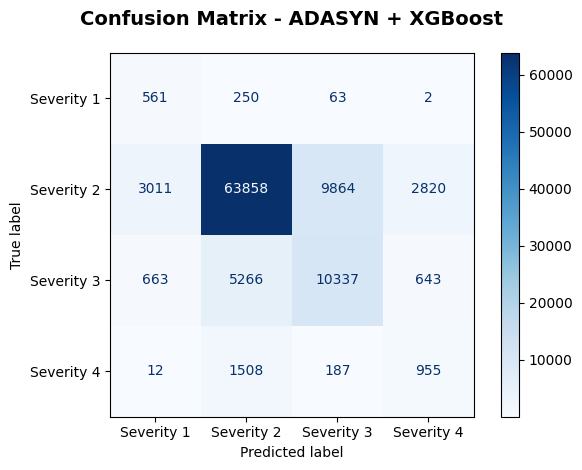


GRID SEARCH - HYPERPARAMETER TUNING
  ✓ Grid Search parametreleri:
    classification__max_depth: [4, 6]
    classification__learning_rate: [0.1, 0.05]

  ✓ Grid Search başlatılıyor (cv=2, toplam 2 fit)...
Fitting 2 folds for each of 4 candidates, totalling 8 fits

  → Grid Search tamamlandı! Süre: 376.05 saniye (6.27 dakika)

  → En iyi parametreler:
    classification__learning_rate: 0.1
    classification__max_depth: 6

  → En iyi F1-Score (weighted): 0.7826

GRIDSEARCH XGBOOST DEĞERLENDİRME
  ✓ Tahminler yapılıyor...

  → Doğruluk (Accuracy): 0.7571
  → Ağırlıklı F1-Skoru: 0.7787
  → Makro F1-Skoru: 0.4774

--------------------------------------------------------------------------------
SINIFLANDIRMA RAPORU
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

  Severity 1       0.14      0.63      0.22       876
  Severity 2       0.90      0.80      0.85     79553
  Severity 3       0.50      0.63 

<Figure size 1000x800 with 0 Axes>

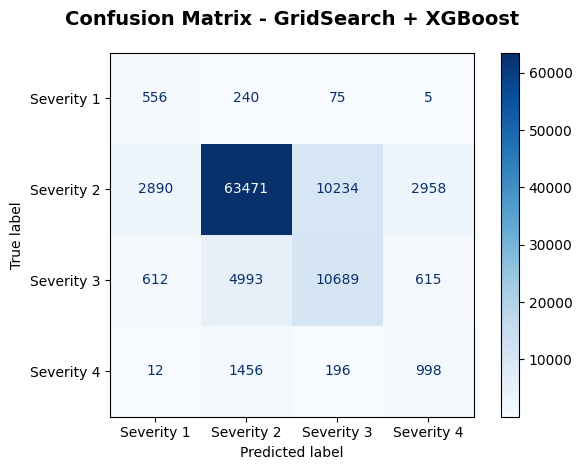


ÖZELLİK ÖNEMİ ANALİZİ

  En Önemli 20 Özellik:
  --------------------------------------------------
  Distance(mi)............................ 0.0766
  Signal_Stop_Present..................... 0.0694
  Crossing................................ 0.0404
  Wind_Direction_Calm..................... 0.0259
  State_SC................................ 0.0259
  State_GA................................ 0.0234
  State_AR................................ 0.0209
  Accident_Duration_Min................... 0.0201
  State_CO................................ 0.0196
  Traffic_Signal.......................... 0.0191
  Wind_Speed(mph)......................... 0.0190
  Astronomical_Twilight_Night............. 0.0173
  Pressure(in)............................ 0.0164
  Day_Name_Tuesday........................ 0.0147
  Day_Name_Wednesday...................... 0.0145
  Wind_Direction_South.................... 0.0139
  State_VA................................ 0.0137
  Day_Name_Thursday....................... 0.0137

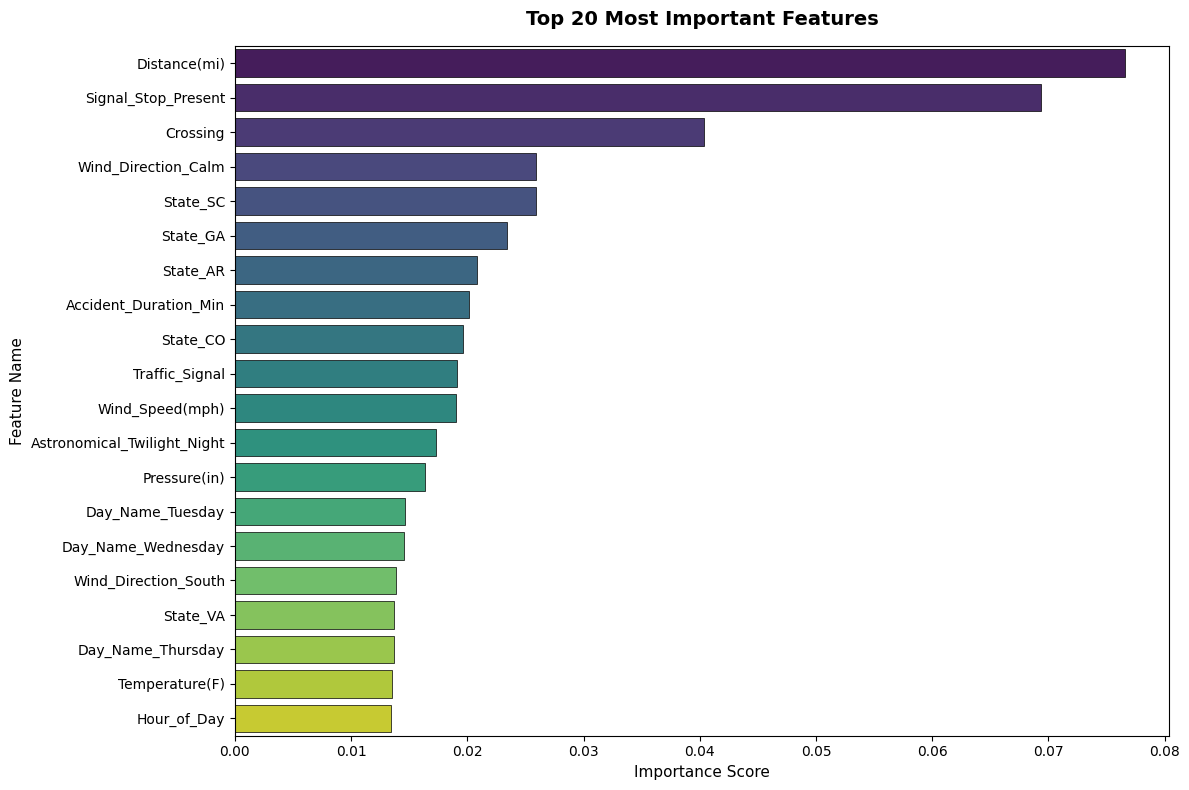


TÜM MODELLERİN KARŞILAŞTIRILMASI

  Model Performans Tablosu:
  ------------------------------------------------------------
                        Accuracy  F1_Weighted
Baseline_LogisticReg     0.79588     0.712776
Baseline_MajorityClass   0.79553     0.704937
SMOTE_XGBoost            0.75714     0.778711
GridSearch_XGBoost       0.75714     0.778711
ADASYN_XGBoost           0.75711     0.778055


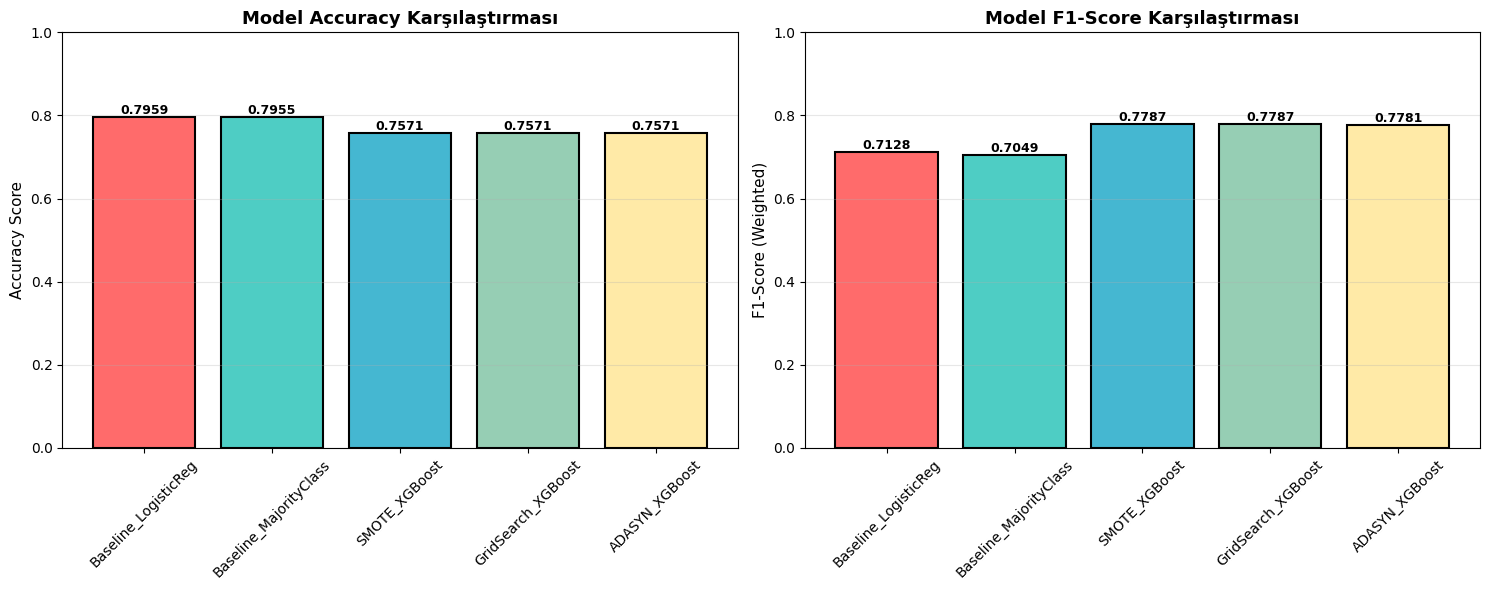


TÜM İŞLEMLER TAMAMLANDI!

  ✓ Veri yükleme ve ön işleme
  ✓ Özellik mühendisliği
  ✓ PCA analizi
  ✓ 2 Baseline model eğitimi
  ✓ SMOTE + XGBoost modeli
  ✓ ADASYN + XGBoost modeli
  ✓ Grid Search ile hiperparametre optimizasyonu
  ✓ Model karşılaştırması



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (classification_report, confusion_matrix, 
                            ConfusionMatrixDisplay, accuracy_score, f1_score)
import warnings
import time

warnings.filterwarnings('ignore')

# ============================================================================
# YAPILANDIRMA PARAMETRELERİ
# ============================================================================
SAMPLE_SIZE = 500000
TEST_RATIO = 0.2
RANDOM_STATE = 42
PCA_COMPONENTS = 0.95  # Varyansın %95'ini tut

MODEL_PARAMS = {
    'objective': 'multi:softmax',
    'num_class': 4,
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

print("✓ Tüm kütüphaneler başarıyla yüklendi!")
print(f"✓ Örnek boyutu: {SAMPLE_SIZE:,}")
print(f"✓ Test oranı: {TEST_RATIO}")
print(f"✓ PCA komponenti: {PCA_COMPONENTS}")


# ============================================================================
# VERİ YÜKLEME VE BÖLME
# ============================================================================
def load_and_split_data(filepath, sample_size, test_size, random_state):
    """Ham veriyi yükler, örnekler ve train/test olarak böler."""
    print("\n" + "="*80)
    print("VERİ YÜKLEME VE BÖLME İŞLEMİ")
    print("="*80)
    
    raw_data = pd.read_csv(filepath)
    print(f"→ Toplam kayıt sayısı: {len(raw_data):,}")
    
    sampled_data = raw_data.sample(n=sample_size, random_state=random_state)
    del raw_data
    print(f"→ Örneklenen kayıt sayısı: {len(sampled_data):,}")
    
    features = sampled_data.drop('Severity', axis=1)
    target = sampled_data['Severity']
    
    X_train, X_test, y_train, y_test = train_test_split(
        features, target, 
        test_size=test_size, 
        random_state=random_state, 
        stratify=target
    )
    
    print(f"→ Eğitim seti: {X_train.shape[0]:,} satır × {X_train.shape[1]} özellik")
    print(f"→ Test seti: {X_test.shape[0]:,} satır × {X_test.shape[1]} özellik")
    
    return X_train, X_test, y_train, y_test


# ============================================================================
# ÖZELLİK MÜHENDİSLİĞİ
# ============================================================================
def engineer_temporal_features(df):
    """Zaman tabanlı özellikler üretir."""
    df['Start_Time'] = pd.to_datetime(df['Start_Time'], errors='coerce')
    df['End_Time'] = pd.to_datetime(df['End_Time'], errors='coerce')
    
    df['Hour_of_Day'] = df['Start_Time'].dt.hour
    df['Day_Name'] = df['Start_Time'].dt.day_name()
    df['Is_Weekend_Day'] = df['Day_Name'].isin(['Saturday', 'Sunday']).astype(int)
    
    rush_hours = [7, 8, 9, 16, 17, 18]
    df['During_Rush_Hour'] = df['Hour_of_Day'].isin(rush_hours).astype(int)
    
    duration_seconds = (df['End_Time'] - df['Start_Time']).dt.total_seconds()
    df['Accident_Duration_Min'] = (duration_seconds / 60).clip(lower=0)
    
    night_hours = list(range(0, 6)) + [22, 23]
    df['Night_Weekend_Combo'] = (
        (df['Is_Weekend_Day'] == 1) & 
        (df['Hour_of_Day'].isin(night_hours))
    ).astype(int)
    
    return df


def engineer_weather_features(df):
    """Hava durumu ile ilgili özellikler üretir."""
    if 'Weather_Condition' in df.columns:
        df['Weather_Condition'] = df['Weather_Condition'].fillna('Clear')
        
        adverse_keywords = [
            'rain', 'snow', 'storm', 'thunder', 'fog', 
            'ice', 'sleet', 'wintry', 'drizzle', 'hail', 'mist'
        ]
        
        pattern = '|'.join(adverse_keywords)
        df['Adverse_Weather'] = (
            df['Weather_Condition']
            .str.lower()
            .str.contains(pattern, na=False)
            .astype(int)
        )
    
    if 'Precipitation(in)' in df.columns:
        df['Precipitation(in)'] = df['Precipitation(in)'].fillna(0.0)
        df['Has_Precipitation'] = (df['Precipitation(in)'] > 0).astype(int)
    
    return df


def engineer_traffic_features(df):
    """Trafik ve yol koşulu özellikleri üretir."""
    if all(col in df.columns for col in ['Traffic_Signal', 'Stop']):
        df['Signal_Stop_Present'] = (
            (df['Traffic_Signal'] == True) | 
            (df['Stop'] == True)
        ).astype(int)
    
    df['Heavy_Traffic_Indicator'] = (
        (df['During_Rush_Hour'] == 1) & 
        (df['Signal_Stop_Present'] == 1)
    ).astype(int)
    
    if 'Junction' in df.columns:
        df['Junction'] = df['Junction'].astype(int)
    
    return df


def engineer_severity_indicators(df):
    """Kaza şiddeti göstergeleri üretir."""
    if all(col in df.columns for col in ['Distance(mi)', 'Accident_Duration_Min']):
        distance_threshold = df['Distance(mi)'].quantile(0.75)
        duration_threshold = df['Accident_Duration_Min'].quantile(0.75)
        
        df['High_Impact_Incident'] = (
            (df['Distance(mi)'] > distance_threshold) & 
            (df['Accident_Duration_Min'] > duration_threshold)
        ).astype(int)
    
    return df


def create_all_features(data):
    """Tüm özellik mühendisliği işlemlerini uygular."""
    print("\n" + "-"*80)
    print("ÖZELLİK MÜHENDİSLİĞİ UYGULANMAKTADIR...")
    print("-"*80)
    
    processed = data.copy()
    
    print("  ✓ Zaman tabanlı özellikler oluşturuluyor...")
    processed = engineer_temporal_features(processed)
    
    print("  ✓ Hava durumu özellikleri oluşturuluyor...")
    processed = engineer_weather_features(processed)
    
    print("  ✓ Trafik özellikleri oluşturuluyor...")
    processed = engineer_traffic_features(processed)
    
    print("  ✓ Şiddet göstergeleri oluşturuluyor...")
    processed = engineer_severity_indicators(processed)
    
    print("  → Özellik mühendisliği tamamlandı.")
    
    return processed


# ============================================================================
# VERİ TEMİZLEME VE ÖN İŞLEME
# ============================================================================
def remove_unnecessary_columns(df):
    """Gereksiz sütunları temizler."""
    columns_to_remove = [
        'ID', 'Source', 'End_Lat', 'End_Lng', 'County', 'Zipcode', 
        'Country', 'Start_Time', 'End_Time', 'Timezone', 'Airport_Code',
        'Weather_Timestamp', 'Wind_Chill(F)', 'Street', 'Description',
        'Weather_Condition', 'City'
    ]
    
    df_cleaned = df.drop(columns=columns_to_remove, errors='ignore')
    return df_cleaned


def handle_outliers(train_df, test_df):
    """Aykırı değerleri kırpar (clipping)."""
    print("\n  ✓ Aykırı değerler işleniyor...")
    
    numerical_cols = [
        'Temperature(F)', 'Wind_Speed(mph)', 'Precipitation(in)',
        'Distance(mi)', 'Accident_Duration_Min', 'Pressure(in)',
        'Humidity(%)', 'Visibility(mi)'
    ]
    
    available_cols = [col for col in numerical_cols if col in train_df.columns]
    
    for column in available_cols:
        lower_bound = train_df[column].quantile(0.01)
        upper_bound = train_df[column].quantile(0.99)
        
        train_df[column] = train_df[column].clip(lower=lower_bound, upper=upper_bound)
        test_df[column] = test_df[column].clip(lower=lower_bound, upper=upper_bound)
    
    return train_df, test_df


def impute_missing_values(train_df, test_df):
    """Eksik değerleri doldurur."""
    print("  ✓ Eksik değerler dolduruluyor...")
    
    fill_strategy = {}
    
    for column in train_df.columns:
        if train_df[column].isnull().sum() > 0:
            if pd.api.types.is_numeric_dtype(train_df[column]):
                fill_strategy[column] = train_df[column].median()
            else:
                mode_values = train_df[column].mode()
                fill_strategy[column] = mode_values[0] if len(mode_values) > 0 else 'Unknown'
    
    train_df = train_df.fillna(value=fill_strategy)
    test_df = test_df.fillna(value=fill_strategy)
    
    return train_df, test_df


def preprocess_data(X_train, X_test):
    """Veri ön işleme adımlarını yönetir."""
    print("\n" + "-"*80)
    print("VERİ TEMİZLEME VE ÖN İŞLEME")
    print("-"*80)
    
    X_train_clean = remove_unnecessary_columns(X_train)
    X_test_clean = remove_unnecessary_columns(X_test)
    
    X_train_clean, X_test_clean = handle_outliers(X_train_clean, X_test_clean)
    X_train_clean, X_test_clean = impute_missing_values(X_train_clean, X_test_clean)
    
    print(f"  → Temizlenmiş veri seti boyutu: {X_train_clean.shape[1]} özellik")
    
    return X_train_clean, X_test_clean


# ============================================================================
# KODLAMA VE ÖLÇEKLENDİRME
# ============================================================================
def encode_and_scale(X_train, X_test):
    """Kategorik değişkenleri kodlar ve sayısal değerleri ölçeklendirir."""
    print("\n" + "-"*80)
    print("KODLAMA VE ÖLÇEKLENDİRME")
    print("-"*80)
    
    categorical_columns = [
        col for col in ['Day_Name', 'State', 'Wind_Direction', 
                       'Sunrise_Sunset', 'Civil_Twilight', 
                       'Nautical_Twilight', 'Astronomical_Twilight']
        if col in X_train.columns
    ]
    
    print(f"  ✓ {len(categorical_columns)} kategorik özellik kodlanıyor...")
    
    X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
    X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)
    
    missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
    for col in missing_cols:
        X_test_encoded[col] = 0
    
    X_test_encoded = X_test_encoded[X_train_encoded.columns]
    
    numeric_columns = X_train_encoded.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"  ✓ {len(numeric_columns)} sayısal özellik ölçeklendiriliyor...")
    
    scaler = StandardScaler()
    
    X_train_final = X_train_encoded.copy()
    X_test_final = X_test_encoded.copy()
    
    X_train_final[numeric_columns] = scaler.fit_transform(X_train_encoded[numeric_columns])
    X_test_final[numeric_columns] = scaler.transform(X_test_encoded[numeric_columns])
    
    print(f"  → Nihai özellik sayısı: {X_train_final.shape[1]}")
    
    return X_train_final, X_test_final, scaler


# ============================================================================
# VERİ GÖRSELLEŞTİRME
# ============================================================================
def plot_class_distribution(y_train, y_test):
    """Sınıf dağılımını görselleştirir."""
    print("\n" + "-"*80)
    print("SINIF DAĞILIMI ANALİZİ")
    print("-"*80)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Train seti
    train_counts = y_train.value_counts().sort_index()
    axes[0].bar(train_counts.index, train_counts.values, color='steelblue', edgecolor='black')
    axes[0].set_title('Eğitim Seti - Sınıf Dağılımı', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Severity Level')
    axes[0].set_ylabel('Frekans')
    axes[0].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(train_counts.values):
        axes[0].text(train_counts.index[i], v + 1000, str(v), ha='center', fontsize=10)
    
    # Test seti
    test_counts = y_test.value_counts().sort_index()
    axes[1].bar(test_counts.index, test_counts.values, color='coral', edgecolor='black')
    axes[1].set_title('Test Seti - Sınıf Dağılımı', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Severity Level')
    axes[1].set_ylabel('Frekans')
    axes[1].grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(test_counts.values):
        axes[1].text(test_counts.index[i], v + 500, str(v), ha='center', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    print("\n  Eğitim Seti:")
    for severity, count in train_counts.items():
        print(f"    Severity {severity}: {count:,} ({count/len(y_train)*100:.2f}%)")
    
    print("\n  Test Seti:")
    for severity, count in test_counts.items():
        print(f"    Severity {severity}: {count:,} ({count/len(y_test)*100:.2f}%)")


def plot_correlation_heatmap(X_train, top_n=20):
    """En önemli özelliklerin korelasyon ısı haritasını çizer."""
    print("\n  ✓ Korelasyon ısı haritası oluşturuluyor...")
    
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns[:top_n]
    corr_matrix = X_train[numeric_cols].corr()
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, 
                linewidths=0.5, cbar_kws={'label': 'Korelasyon'})
    plt.title(f'İlk {top_n} Özellik - Korelasyon Matrisi', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# ============================================================================
# PCA ANALİZİ
# ============================================================================
def apply_pca_and_visualize(X_train, X_test, variance_ratio=0.95):
    """PCA uygular ve görselleştirir."""
    print("\n" + "="*80)
    print("PCA (Temel Bileşen Analizi)")
    print("="*80)
    
    pca = PCA(n_components=variance_ratio, random_state=RANDOM_STATE)
    
    print(f"  ✓ PCA uygulanıyor (Varyans: %{variance_ratio*100})...")
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    n_components = pca.n_components_
    print(f"  → Seçilen bileşen sayısı: {n_components}")
    print(f"  → Açıklanan toplam varyans: %{pca.explained_variance_ratio_.sum()*100:.2f}")
    
    # Kümülatif varyans grafiği
    cumsum_variance = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(cumsum_variance)+1), cumsum_variance, 
             marker='o', linestyle='-', color='navy', markersize=4)
    plt.axhline(y=variance_ratio, color='red', linestyle='--', 
                label=f'{variance_ratio*100}% Varyans Eşiği')
    plt.xlabel('Bileşen Sayısı')
    plt.ylabel('Kümülatif Açıklanan Varyans')
    plt.title('PCA - Kümülatif Varyans', fontweight='bold')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # İlk 20 bileşenin varyansı
    plt.subplot(1, 2, 2)
    components_to_show = min(20, n_components)
    plt.bar(range(1, components_to_show+1), 
            pca.explained_variance_ratio_[:components_to_show],
            color='teal', edgecolor='black')
    plt.xlabel('Bileşen')
    plt.ylabel('Açıklanan Varyans Oranı')
    plt.title(f'İlk {components_to_show} Bileşen - Varyans Dağılımı', fontweight='bold')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return X_train_pca, X_test_pca, pca


# ============================================================================
# BASELINE MODEL 1: MAJORITY CLASS CLASSIFIER
# ============================================================================
class MajorityClassClassifier(BaseEstimator, ClassifierMixin):
    """Her zaman en çok görülen sınıfı tahmin eden baseline model."""
    
    def fit(self, X, y):
        self.majority_class_ = pd.Series(y).mode()[0]
        return self
    
    def predict(self, X):
        return np.full(X.shape[0], self.majority_class_)


# ============================================================================
# MODEL EĞİTİMİ VE DEĞERLENDİRME
# ============================================================================
def train_baseline_majority(X_train, y_train, X_test, y_test):
    """Baseline 1: Majority Class Classifier."""
    print("\n" + "="*80)
    print("BASELINE MODEL 1: MAJORITY CLASS CLASSIFIER")
    print("="*80)
    
    y_train_adj = y_train - 1
    y_test_adj = y_test - 1
    
    model = MajorityClassClassifier()
    
    print("  ✓ Model eğitiliyor...")
    start = time.time()
    model.fit(X_train, y_train_adj)
    duration = time.time() - start
    
    print(f"  → Eğitim tamamlandı! Süre: {duration:.4f} saniye")
    print(f"  → En çok görülen sınıf: {model.majority_class_}")
    
    print("\n  ✓ Tahminler yapılıyor...")
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test_adj, y_pred)
    f1_weighted = f1_score(y_test_adj, y_pred, average='weighted', zero_division=0)
    
    print(f"\n  → Doğruluk (Accuracy): {acc:.4f}")
    print(f"  → Ağırlıklı F1-Skoru: {f1_weighted:.4f}")
    
    return model, y_pred, acc, f1_weighted


def train_baseline_logistic(X_train, y_train, X_test, y_test):
    """Baseline 2: Logistic Regression."""
    print("\n" + "="*80)
    print("BASELINE MODEL 2: LOGISTIC REGRESSION")
    print("="*80)
    
    y_train_adj = y_train - 1
    y_test_adj = y_test - 1
    
    model = LogisticRegression(
        max_iter=500,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        multi_class='multinomial',
        solver='lbfgs'
    )
    
    print("  ✓ Model eğitiliyor...")
    start = time.time()
    model.fit(X_train, y_train_adj)
    duration = time.time() - start
    
    print(f"  → Eğitim tamamlandı! Süre: {duration:.2f} saniye")
    
    print("\n  ✓ Tahminler yapılıyor...")
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test_adj, y_pred)
    f1_weighted = f1_score(y_test_adj, y_pred, average='weighted')
    
    print(f"\n  → Doğruluk (Accuracy): {acc:.4f}")
    print(f"  → Ağırlıklı F1-Skoru: {f1_weighted:.4f}")
    
    return model, y_pred, acc, f1_weighted


def train_smote_xgboost(X_train, y_train, model_params):
    """SMOTE + XGBoost pipeline oluşturur ve eğitir."""
    print("\n" + "="*80)
    print("MODEL 3: SMOTE + XGBoost")
    print("="*80)
    
    y_train_adjusted = y_train - 1
    
    print(f"  → Sınıf dağılımı: {np.bincount(y_train_adjusted)}")
    print("\n  ✓ SMOTE + XGBoost pipeline oluşturuluyor...")
    
    smote_sampler = SMOTE(random_state=RANDOM_STATE, n_jobs=-1)
    xgb_model = xgb.XGBClassifier(**model_params)
    
    pipeline = ImbPipeline([
        ('sampling', smote_sampler),
        ('classification', xgb_model)
    ])
    
    print("  ✓ Model eğitimi başlatılıyor...")
    
    start = time.time()
    pipeline.fit(X_train, y_train_adjusted)
    duration = time.time() - start
    
    print(f"\n  → Eğitim tamamlandı! Süre: {duration:.2f} saniye ({duration/60:.2f} dakika)")
    
    return pipeline, y_train_adjusted


def train_adasyn_xgboost(X_train, y_train, model_params):
    """ADASYN + XGBoost pipeline oluşturur ve eğitir."""
    print("\n" + "="*80)
    print("MODEL 4: ADASYN + XGBoost")
    print("="*80)
    
    y_train_adjusted = y_train - 1
    
    print(f"  → Sınıf dağılımı: {np.bincount(y_train_adjusted)}")
    print("\n  ✓ ADASYN + XGBoost pipeline oluşturuluyor...")
    
    adasyn_sampler = ADASYN(random_state=RANDOM_STATE, n_jobs=-1)
    xgb_model = xgb.XGBClassifier(**model_params)
    
    pipeline = ImbPipeline([
        ('sampling', adasyn_sampler),
        ('classification', xgb_model)
    ])
    
    print("  ✓ Model eğitimi başlatılıyor...")
    
    start = time.time()
    pipeline.fit(X_train, y_train_adjusted)
    duration = time.time() - start
    
    print(f"\n  → Eğitim tamamlandı! Süre: {duration:.2f} saniye ({duration/60:.2f} dakika)")
    
    return pipeline, y_train_adjusted


def evaluate_model(model, X_test, y_test, model_name="Model"):
    """Modeli değerlendirir ve metrikleri hesaplar."""
    print("\n" + "="*80)
    print(f"{model_name.upper()} DEĞERLENDİRME")
    print("="*80)
    
    y_test_adjusted = y_test - 1
    
    print("  ✓ Tahminler yapılıyor...")
    predictions = model.predict(X_test)
    
    acc = accuracy_score(y_test_adjusted, predictions)
    f1_weighted = f1_score(y_test_adjusted, predictions, average='weighted')
    f1_macro = f1_score(y_test_adjusted, predictions, average='macro')
    
    print(f"\n  → Doğruluk (Accuracy): {acc:.4f}")
    print(f"  → Ağırlıklı F1-Skoru: {f1_weighted:.4f}")
    print(f"  → Makro F1-Skoru: {f1_macro:.4f}")
    
    print("\n" + "-"*80)
    print("SINIFLANDIRMA RAPORU")
    print("-"*80)
    
    class_names = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
    report = classification_report(y_test_adjusted, predictions, 
                                   target_names=class_names)
    print(report)
    
    return predictions, y_test_adjusted, acc, f1_weighted


def plot_confusion_matrix(y_true, y_pred, model_name="Model"):
    """Karmaşıklık matrisini görselleştirir."""
    print(f"\n  ✓ {model_name} - Karmaşıklık matrisi oluşturuluyor...")
    
    cm = confusion_matrix(y_true, y_pred)
    class_labels = ['Severity 1', 'Severity 2', 'Severity 3', 'Severity 4']
    
    plt.figure(figsize=(10, 8))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(cmap='Blues', values_format='d')
    
    plt.title(f'Confusion Matrix - {model_name}', 
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def analyze_feature_importance(pipeline, feature_names, top_n=20):
    """Özellik önemlerini analiz eder ve görselleştirir."""
    print("\n" + "="*80)
    print("ÖZELLİK ÖNEMİ ANALİZİ")
    print("="*80)
    
    classifier = pipeline.named_steps['classification']
    
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': classifier.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\n  En Önemli {top_n} Özellik:")
    print("  " + "-"*50)
    for idx, row in importances.head(top_n).iterrows():
        print(f"  {row['Feature']:.<40} {row['Importance']:.4f}")
    
    plt.figure(figsize=(12, 8))
    top_features = importances.head(top_n)
    
    sns.barplot(data=top_features, x='Importance', y='Feature', 
               palette='viridis', edgecolor='black', linewidth=0.5)
    
    plt.title(f'Top {top_n} Most Important Features', 
             fontsize=14, fontweight='bold', pad=15)
    plt.xlabel('Importance Score', fontsize=11)
    plt.ylabel('Feature Name', fontsize=11)
    plt.tight_layout()
    plt.show()


def perform_grid_search(X_train, y_train, base_params):
    """XGBoost için Grid Search yapar (cv=2)."""
    print("\n" + "="*80)
    print("GRID SEARCH - HYPERPARAMETER TUNING")
    print("="*80)
    
    y_train_adjusted = y_train - 1
    
    param_grid = {
        'classification__max_depth': [4, 6],
        'classification__learning_rate': [0.1, 0.05]
    }
    
    print("  ✓ Grid Search parametreleri:")
    for key, values in param_grid.items():
        print(f"    {key}: {values}")
    
    smote_sampler = SMOTE(random_state=RANDOM_STATE, n_jobs=-1)
    xgb_model = xgb.XGBClassifier(**base_params)
    
    pipeline = ImbPipeline([
        ('sampling', smote_sampler),
        ('classification', xgb_model)
    ])
    
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=2,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=1
    )
    
    print("\n  ✓ Grid Search başlatılıyor (cv=2, toplam 2 fit)...")
    start = time.time()
    grid_search.fit(X_train, y_train_adjusted)
    duration = time.time() - start
    
    print(f"\n  → Grid Search tamamlandı! Süre: {duration:.2f} saniye ({duration/60:.2f} dakika)")
    print(f"\n  → En iyi parametreler:")
    for param, value in grid_search.best_params_.items():
        print(f"    {param}: {value}")
    print(f"\n  → En iyi F1-Score (weighted): {grid_search.best_score_:.4f}")
    
    return grid_search, y_train_adjusted


def compare_all_models(results_dict):
    """Tüm modellerin performansını karşılaştırır."""
    print("\n" + "="*80)
    print("TÜM MODELLERİN KARŞILAŞTIRILMASI")
    print("="*80)
    
    comparison_df = pd.DataFrame(results_dict).T
    comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
    
    print("\n  Model Performans Tablosu:")
    print("  " + "-"*60)
    print(comparison_df.to_string())
    
    # Görselleştirme
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    models = comparison_df.index
    accuracy = comparison_df['Accuracy'].values
    f1_scores = comparison_df['F1_Weighted'].values
    
    # Accuracy karşılaştırması
    bars1 = axes[0].bar(models, accuracy, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'],
                        edgecolor='black', linewidth=1.5)
    axes[0].set_ylabel('Accuracy Score', fontsize=11)
    axes[0].set_title('Model Accuracy Karşılaştırması', fontsize=13, fontweight='bold')
    axes[0].set_ylim([0, 1])
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].tick_params(axis='x', rotation=45)
    
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # F1-Score karşılaştırması
    bars2 = axes[1].bar(models, f1_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'],
                        edgecolor='black', linewidth=1.5)
    axes[1].set_ylabel('F1-Score (Weighted)', fontsize=11)
    axes[1].set_title('Model F1-Score Karşılaştırması', fontsize=13, fontweight='bold')
    axes[1].set_ylim([0, 1])
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].tick_params(axis='x', rotation=45)
    
    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# ANA İŞ AKIŞI
# ============================================================================
print("\n" + "="*80)
print("ANA İŞ AKIŞI BAŞLATILIYOR")
print("="*80)

# 1. VERİ YÜKLEME
X_train, X_test, y_train, y_test = load_and_split_data(
    'US_Accidents_March23.csv',
    SAMPLE_SIZE,
    TEST_RATIO,
    RANDOM_STATE
)

# 2. SINIF DAĞILIMI GÖRSELLEŞTİRME
plot_class_distribution(y_train, y_test)

# 3. ÖZELLİK MÜHENDİSLİĞİ
X_train_featured = create_all_features(X_train)
X_test_featured = create_all_features(X_test)

# 4. VERİ TEMİZLEME
X_train_clean, X_test_clean = preprocess_data(X_train_featured, X_test_featured)

# 5. KODLAMA VE ÖLÇEKLENDİRME
X_train_final, X_test_final, scaler = encode_and_scale(X_train_clean, X_test_clean)

# 6. KORELASYON ANALIZI
plot_correlation_heatmap(X_train_final, top_n=20)

# 7. PCA ANALIZI
X_train_pca, X_test_pca, pca = apply_pca_and_visualize(
    X_train_final, X_test_final, variance_ratio=PCA_COMPONENTS
)

# Sonuçları saklamak için dictionary
results = {}

# 8. BASELINE MODEL 1: MAJORITY CLASS
baseline1, pred1, acc1, f1_1 = train_baseline_majority(
    X_train_final, y_train, X_test_final, y_test
)
results['Baseline_MajorityClass'] = {'Accuracy': acc1, 'F1_Weighted': f1_1}
plot_confusion_matrix(y_test - 1, pred1, "Baseline 1: Majority Class")

# 9. BASELINE MODEL 2: LOGISTIC REGRESSION
baseline2, pred2, acc2, f1_2 = train_baseline_logistic(
    X_train_pca, y_train, X_test_pca, y_test
)
results['Baseline_LogisticReg'] = {'Accuracy': acc2, 'F1_Weighted': f1_2}
plot_confusion_matrix(y_test - 1, pred2, "Baseline 2: Logistic Regression")

# 10. MODEL 3: SMOTE + XGBoost
smote_model, y_train_adj = train_smote_xgboost(X_train_final, y_train, MODEL_PARAMS)
pred3, y_test_adj, acc3, f1_3 = evaluate_model(smote_model, X_test_final, y_test, "SMOTE + XGBoost")
results['SMOTE_XGBoost'] = {'Accuracy': acc3, 'F1_Weighted': f1_3}
plot_confusion_matrix(y_test_adj, pred3, "SMOTE + XGBoost")
analyze_feature_importance(smote_model, X_train_final.columns, top_n=20)

# 11. MODEL 4: ADASYN + XGBoost
adasyn_model, _ = train_adasyn_xgboost(X_train_final, y_train, MODEL_PARAMS)
pred4, y_test_adj, acc4, f1_4 = evaluate_model(adasyn_model, X_test_final, y_test, "ADASYN + XGBoost")
results['ADASYN_XGBoost'] = {'Accuracy': acc4, 'F1_Weighted': f1_4}
plot_confusion_matrix(y_test_adj, pred4, "ADASYN + XGBoost")

# 12. GRID SEARCH ILE HYPERPARAMETER TUNING
grid_model, _ = perform_grid_search(X_train_final, y_train, MODEL_PARAMS)
pred5, y_test_adj, acc5, f1_5 = evaluate_model(
    grid_model.best_estimator_, X_test_final, y_test, "GridSearch XGBoost"
)
results['GridSearch_XGBoost'] = {'Accuracy': acc5, 'F1_Weighted': f1_5}
plot_confusion_matrix(y_test_adj, pred5, "GridSearch + XGBoost")
analyze_feature_importance(grid_model.best_estimator_, X_train_final.columns, top_n=20)

# 13. TÜM MODELLERİ KARŞILAŞTIR
compare_all_models(results)

print("\n" + "="*80)
print("TÜM İŞLEMLER TAMAMLANDI!")
print("="*80)
print("\n  ✓ Veri yükleme ve ön işleme")
print("  ✓ Özellik mühendisliği")
print("  ✓ PCA analizi")
print("  ✓ 2 Baseline model eğitimi")
print("  ✓ SMOTE + XGBoost modeli")
print("  ✓ ADASYN + XGBoost modeli")
print("  ✓ Grid Search ile hiperparametre optimizasyonu")
print("  ✓ Model karşılaştırması")
print("\n" + "="*80)